In [1]:
import numpy as np

import torch
import torch.nn as nn

import math

from torchvision import models

import cv2

In [2]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [44]:
from dataset import PennFudanDataset
from transfroms import get_transform

from utils import show_image, show_anchors
from utils import generate_anchors, process_anchors, find_jaccard_overlap

import time
from utils import format_time

from loss import BoxLoss
from train import run_loader, get_device

In [4]:
dataset = PennFudanDataset('../PennFudanPed', get_transform(train=False))

In [5]:
image, target = dataset[0]

In [6]:
target

{'boxes': tensor([[0.2844, 0.3377, 0.5385, 0.8022],
         [0.7496, 0.3172, 0.9553, 0.9049]]),
 'labels': tensor([1, 1])}

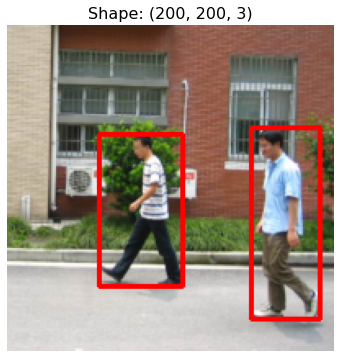

In [7]:
show_image(dataset, 0)

In [8]:
anchors = generate_anchors()

In [9]:
# anchors = anchors[:5]
anchors.shape

torch.Size([441, 4])

In [10]:
# each anchor we need to match gt_box and binary label - positive
# or 0 label and no box - negative

# We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes.
# Anchors that are neither positive nor negative do not contribute to the training objective.

# + add delatas for loss

In [11]:
anchor_labels, gt_offsets = process_anchors(anchors, target['boxes'])

In [16]:
def get_top_n_anchors(anchors, gt_boxes):
    # anchors (N1, 4)
    # gt_boxes (N2, 4)
 
    jaccard = find_jaccard_overlap(anchors, gt_boxes) # (N1, N2)
    
    prior_max_iou, prior_gt_box_idx = jaccard.max(1) # (N1), (N1)
    
    top_n = 10
    _, top_priors_idx = prior_max_iou.sort(descending=True)
    return anchors[top_priors_idx[:top_n]], prior_max_iou[top_priors_idx[:top_n]]

In [17]:
top_n_anchors, top_n_iou = get_top_n_anchors(anchors, target['boxes'])

In [18]:
top_n_iou

tensor([0.4745, 0.4732, 0.4732, 0.4691, 0.4008, 0.3733, 0.3733, 0.3644, 0.3631,
        0.3602])

In [19]:
N = 9
start = 24
# show_anchors(image, target['boxes'], anchors[start*N:(start+1)*N])
# show_anchors(image, target['boxes'], anchors)

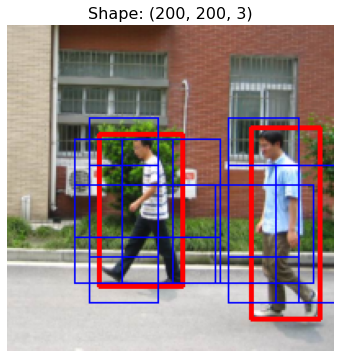

In [20]:
show_anchors(image, target['boxes'], top_n_anchors)

## Test Model

In [21]:
def collate_fn(batch):
    # batch: list[tuple]
    # each tuple is (image, target) dictionary
    # turns it into a single tuple (in this case of len == 2)
    
    # TODO: why it's always tuple  
    # print(f'collate_fn, {len(batch)}, {list(zip(*batch))[0]}, {type(list(zip(*batch))[0])}')
    # return list(zip(*batch))
    
    # torch.stack here? for images?
    # do we distinguish targets between images?
    
    return tuple(zip(*batch))

In [22]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

In [23]:
images, targets = next(iter(data_loader))
# images = next(iter(data_loader))

In [24]:
type(images), type(targets)

(tuple, tuple)

In [25]:
images = torch.stack(images, dim=0)

In [26]:
images.shape

torch.Size([8, 3, 200, 200])

In [27]:
# targets

In [28]:
from faster_rcnn import faster_rcnn

In [29]:
net = faster_rcnn()

In [30]:
offsets, labels = net(images)

In [31]:
offsets.shape, labels.shape

(torch.Size([8, 441, 4]), torch.Size([8, 441, 1]))

In [33]:
offsets.shape

torch.Size([8, 441, 4])

In [45]:
device = get_device()

No GPU available, using the CPU instead.


In [54]:
criterion = BoxLoss(device)

In [55]:
loss = criterion(labels, offsets, targets)

box loss: 2.024312973022461
cls loss: 0.6981790065765381


In [56]:
loss

tensor(2.7225, grad_fn=<AddBackward0>)

In [57]:
np.log(1/2)

-0.6931471805599453

## Train Model

In [686]:
# device = get_device()

No GPU available, using the CPU instead.


In [36]:
model = faster_rcnn()

In [37]:
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

In [58]:
len(train_loader)

22

In [41]:
params = {
    'learning_rate' : 0.01,
    'weight_decay'  : 0,
    'num_epoch'     : 2
}


run_loader(model, train_loader, None, **params)

No GPU available, using the CPU instead.
[train] index:  0, loss = 2.35362, time: 0:00:01
[train] index:  1, loss = 1.79450, time: 0:00:03
[train] index:  2, loss = 1.59764, time: 0:00:06
[train] index:  3, loss = 1.38100, time: 0:00:08
[train] index:  4, loss = 1.48053, time: 0:00:11
[train] index:  5, loss = 1.48169, time: 0:00:13
[train] index:  6, loss = 1.49604, time: 0:00:15
[train] index:  7, loss = 1.23742, time: 0:00:18
[train] index:  8, loss = 1.37399, time: 0:00:20
[train] index:  9, loss = 1.27851, time: 0:00:23
[train] index: 10, loss = 1.29793, time: 0:00:25
[train] index: 11, loss = 1.09903, time: 0:00:28
[train] index: 12, loss = 1.06804, time: 0:00:30
[train] index: 13, loss = 1.13031, time: 0:00:32
[train] index: 14, loss = 1.07132, time: 0:00:35
[train] index: 15, loss = 1.28580, time: 0:00:37
[train] index: 16, loss = 1.08461, time: 0:00:40
[train] index: 17, loss = 0.96494, time: 0:00:42
[train] index: 18, loss = 1.06471, time: 0:00:45
[train] index: 19, loss = 1.

{}